# Business Case

The business in question, Wells Fargo, is looking to understand how Generative AI and Natural Language Processing, as cutting edge technologies, could be utilized to optimize operations for the bank. 

This Jupiter Notebook represents a potential use cased titled:

## 'A Statistical Action Assistant', the road to a Statistical Action Model. 

The power of this "Model" is that is reduced overhead time associated with re-writing and configuring code.  

It is also entirely scalable through multiple files into the vector store, making it essentially a jailbroken ChatGPT agent, as seen from GPT4. 

Further modules could be added which add standardized reporting, further method classes, and more. 

In [4]:

OPENAI_API = input("Please submit your open APIKey in order to continue: ")


In [13]:
from typing_extensions import override 
from openai import AssistantEventHandler 
from openai import OpenAI
from SAM_pb_NLP_Tools import DecisionTreeMethods, run_method_by_name

client = OpenAI(api_key = OPENAI_API)

In [6]:
statistical_method_router = client.beta.assistants.create(
    name = "Statistical_Method_Router",
    instructions = "You are a helpful assistant that can guide users to the right statistical methods for their research questions based on the files provided to you.",
    tools =[{"type": "file_search"}],
    model = "gpt-4o",
    temperature = 0, #we do not want creativity, we want as direct and on point as possible. 
)

In [8]:
# Create a vector store called "Statistical_Methods" that will store the statistical methods that the assistant will use to guide users.
vector_store = client.beta.vector_stores.create(name="Statistical Methods")
 
# Ready the files for upload to OpenAI
file_paths = ["/workspaces/AI-ML-Finance-Course/OpenAIChatBot/SAM_pb_NLP_Tools.py"]
file_streams = [open(path, "rb") for path in file_paths]
 
# Use the upload and poll SDK helper to upload the files, add them to the vector store,
# and poll the status of the file batch for completion.
file_batch = client.beta.vector_stores.file_batches.upload_and_poll(
  vector_store_id=vector_store.id, files=file_streams
)
 
# You can print the status and the file counts of the batch to see the result of this operation.
print(file_batch.status)
print(file_batch.file_counts)



completed
FileCounts(cancelled=0, completed=1, failed=0, in_progress=0, total=1)


In [9]:
#This method is important for routing the files back to the assistant generated above. 

statistical_method_router = client.beta.assistants.update(
  assistant_id=statistical_method_router.id,
  tool_resources={"file_search": {"vector_store_ids": [vector_store.id]}},
)

In [14]:
# This class is the stream which puts together the tokens generated by the model. 

class EventHandler(AssistantEventHandler):
    @override
    def on_text_created(self, text) -> None:
        print(f"\n", end= "", flush=True)
              
    @override 
    def on_text_delta(self, delta, snapshot): 
        print(delta.value, end= "", flush = True)

    def on_tool_call_created(self, tool_call): 
        print(f"\n", flush=True)

    def on_tool_call_delta(self, delta, snapshot): 
        if delta.type == 'code_interpreter':
            if delta.code_interpreter.input:
                print(delta.code_interpreter.input, end="", flush=True)
        if delta.code_interpreter.outputs:
            print(f"\n\noutput >", flush=True)
            for output in delta.code_interpreter.outputs:
                if output.type == "logs":
                    print(f"\n{output.logs}", flush=True)

# this method creates the routine for the user to sollict the bot and build out the statistical method in question. 

def runtime():
    continuity_check = 'yes'

    #opportunity, given more time, to create a login here to track past messages based on users email

    thread = client.beta.threads.create() #initiates the "conversation log"

    message = client.beta.threads.messages.create(
        thread_id = thread.id,
        role = "assistant",
        content = "Remember to always utilize the methods from the file provided to you."
    )

    #it's important to note that OpenAI has a method which can use methods defined from the files

    while continuity_check == 'yes':

        message = client.beta.threads.messages.create(
            thread_id = thread.id,
            role = "user",
            content = input("What is your research question? ")
        )

        # Then, we use the `stream` SDK helper 
        # with the `EventHandler` class to create the Run 
        # and stream the response.
 
        with client.beta.threads.runs.stream(
            thread_id=thread.id,
            assistant_id= statistical_method_router.id,
            instructions="Return just the name of the method from the provided file that should be called. In the format of tool There should be nothing else. Do not add parathesis. If the method is not found within the file, you should return We do not have that capabiltity yet, sorry",
            event_handler= EventHandler(),
        ) as stream:
          stream.until_done()

        continuity_check = input("Do you have another research question? (yes/no) ")

        if continuity_check == 'no':
            print("\nThank you for using the Statistical Method Router. Goodbye!")
        else:
            continuity_check = 'yes'



In [16]:
# Call the runtime function and get the name of the method to call

runtime()

# See improvements below. 




decisiontreeclassifier
Thank you for using the Statistical Method Router. Goodbye!


Here are the columns in your dataset: 
Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order', 'fraud'],
      dtype='object')

--- Model Performance Metrics ---
Accuracy: 0.98
Confusion Matrix:
[[179896   2472]
 [  1621  16011]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    182368
         1.0       0.87      0.91      0.89     17632

    accuracy                           0.98    200000
   macro avg       0.93      0.95      0.94    200000
weighted avg       0.98      0.98      0.98    200000



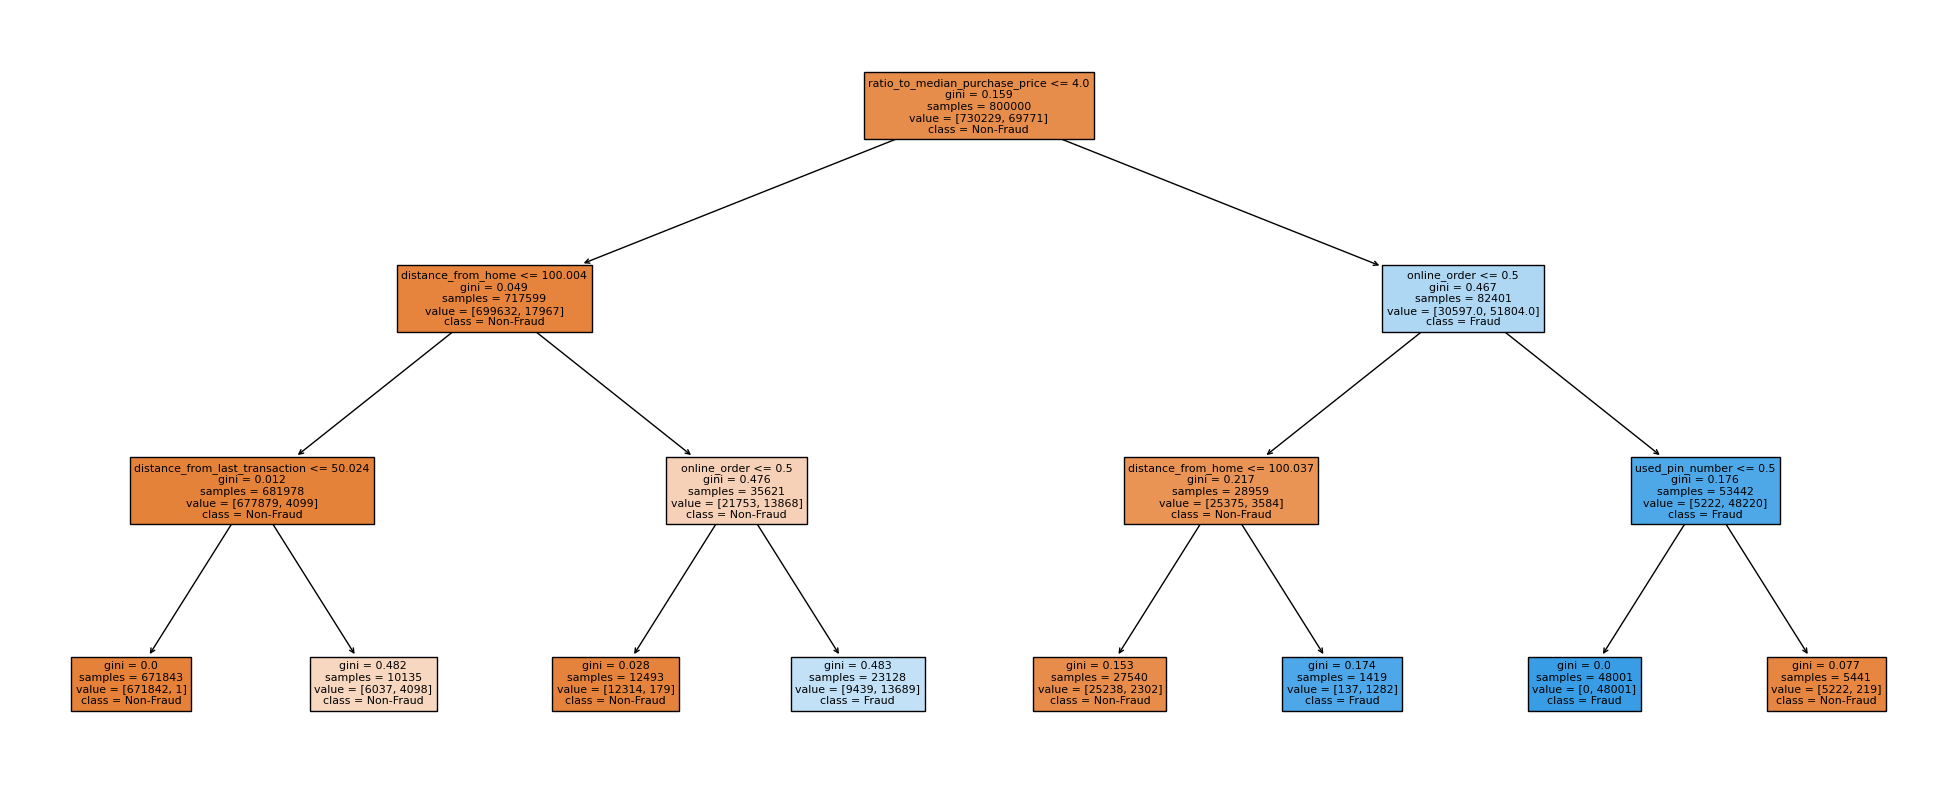

In [18]:
#The bridge from the output text by the GPT assistant to the following method execution is the next step in bridging the automation. 

#https://raw.githubusercontent.com/marhcouto/fraud-detection/master/data/card_transdata.csv?raw=true, here is an example CSV for using the decisiontree method included in the codebase.

#it is necessary to initialize all classes across the different files. That is another add on to this project. This is seen below.

dtm = DecisionTreeMethods()

runner = 'yes'
while runner == 'yes':
    output_run_check = input("Would you like to run one of the outputted methods above? (yes / no)")

    if output_run_check == 'yes':
        method_name = input("Copy and paste the name of the method you would like to run: ").strip()
        run_method_by_name(dtm, method_name)
    elif output_run_check == 'no':
        print("Thank you for using the Statistical Method Router. Goodbye!")
        runner = 'no'
    else:
        print("Invalid input. Please try again.")